In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


In [3]:
# Package
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout

from keras.activations import softmax
from keras.activations import elu
from keras.activations import relu
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization

from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import Database

In [1]:
train_path = "/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip"
test_path = "/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip"

files = "/kaggle/working/"

import zipfile

with zipfile.ZipFile(train_path, 'r') as zipp:
    zipp.extractall(files)
    
with zipfile.ZipFile(test_path, 'r') as zipp:
    zipp.extractall(files)

In [5]:
image_dir = "../working/train/"

filenames = os.listdir(image_dir)
labels = [x.split(".")[0] for x in filenames]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,cat.5714.jpg,cat
1,cat.3100.jpg,cat
2,cat.7725.jpg,cat
3,dog.10952.jpg,dog
4,cat.10099.jpg,cat


# Parameter setting

In [13]:
#from tensorflow import set_random_seed
SEED = 42
#np.random.seed(SEED)
#set_random_seed(SEED)
NUM_CLASSES = 2
IMG_DIM = 224  
BATCH_SIZE = 100
CHANNEL_SIZE = 3
NUM_EPOCHS = 30
TRAIN_DIR = '/kaggle/working/train'
TEST_DIR = '/kaggle/working/test'
FREEZE_LAYERS = 2  # freeze the first this many layers for training

# Train-test split

In [8]:
# train test split using dataframe
from sklearn.model_selection import train_test_split

labels = data['label']

x_train, x_val = train_test_split(data, test_size=0.2, stratify=labels, random_state = SEED)
print('The shape of train data',x_train.shape)
print('The shape of test data',x_val.shape)

The shape of train data (20000, 2)
The shape of test data (5000, 2)


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [9]:
x_train.head()

,filename,label
15026,dog.9982.jpg,dog
9963,cat.3120.jpg,cat
24527,dog.5541.jpg,dog
2574,dog.12297.jpg,dog
15978,dog.5784.jpg,dog


# Data Prep

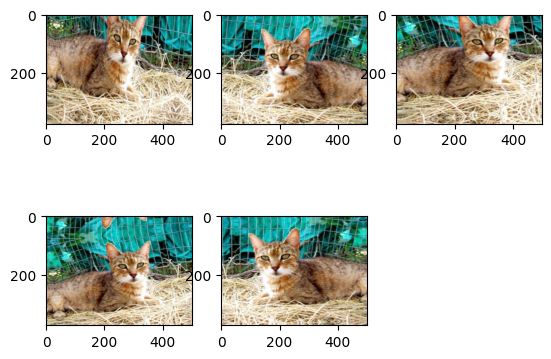

In [160]:
# Creating the imageDatagenerator Instance 
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Creating the ImageDataGenerator instance
datagenerator = ImageDataGenerator(#rescale=1./255,
                                    rotation_range = 10,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

# Load and preprocess an example image
imgPath = f"/kaggle/working/train/cat.11532.jpg"
img = load_img(imgPath)
data = img_to_array(img)
samples = np.expand_dims(data, 0)

# Generate augmented images using the datagenerator instance
it = datagenerator.flow(samples, batch_size=1)

# Display augmented images
for i in range(5):
    plt.subplot(230 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

plt.show()

In [10]:
# Creating the imageDatagenerator
train_datagenerator = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 10,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)
test_datagenerator = ImageDataGenerator(rescale=1./255)

In [15]:
# Applying image data generator to train and test data
train_generator = train_datagenerator.flow_from_dataframe(
    dataframe=x_train,
    directory='train/',  # Directory containing the image files
    x_col='filename',   # Column with file names
    y_col='label',      # Column with class labels
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    batch_size=BATCH_SIZE,
    target_size=(IMG_DIM, IMG_DIM)
)

val_generator = test_datagenerator.flow_from_dataframe(
    dataframe=x_train,
    directory='train/',  # Directory containing the image files
    x_col='filename',   # Column with file names
    y_col='label',      # Column with class labels
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    batch_size=BATCH_SIZE,
    target_size=(IMG_DIM, IMG_DIM)
)

Found 20000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.


In [16]:
# Calculate the maximum number of steps for training generator
max_steps_training = len(train_generator)

# Calculate the maximum number of steps for validation generator
max_steps_validation = len(val_generator)

# Print the results
print("Maximum steps for training generator:", max_steps_training)
print("Maximum steps for validation generator:", max_steps_validation)

Maximum steps for training generator: 200
Maximum steps for validation generator: 200


报错1

In [ ]:
#from tensorflow.keras import optimizers

#sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
#model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

# Resnet

In [37]:
resnet_weights_path = '/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
#pip install tensorflow

In [119]:
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

#model = Sequential()
#model.add(ResNet50(include_top=True, weights='imagenet', input_shape=(224, 224, 3)))
# Add your custom layers on top of ResNet50
# model.add(Dense(NUM_CLASSES, activation='softmax'))
#model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
#model.layers[0].trainable = False

In [ ]:
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.models import Model

#base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
# Create a custom model by adding your own layers on top of the base model
#x = Flatten()(base_model.output)
#x = Dense(NUM_CLASSES, activation='softmax')(x)
#custom_model = Model(inputs=base_model.input, outputs=x)

# Load weights for the base model if needed
# base_model.load_weights(weights_path, by_name=True)

# Now you can use the custom_model for your task

In [82]:
def Vgg16():
    input_tensor = Input(shape=(img_dim, img_dim, CHANNEL))
    vgg16 = VGG16(include_top=False, weights='imagenet',
                  input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
    top_model.add(Dense(512, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(256, activation='relu'))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    model_resnet = Model(input=vgg16.input, output=top_model(vgg16.output))
    for layer in model.layers[:15]:
        layer.trainable = False

    return model_resnet

In [83]:
model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_26[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [78]:
from keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense
from keras.applications import ResNet50
from keras.models import Model

def create_resnet(img_dim, CHANNEL, n_class):
    input_tensor = Input(shape=(img_dim, img_dim, CHANNEL))
    
    # 使用预训练的 ResNet50 模型，并加载权重
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    #base_model.load_weights('/kaggle/input/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    
#     # 在基础模型后添加自定义层
#     x = GlobalAveragePooling2D()(base_model.output)
#     x = BatchNormalization()(x)
#     x = Dropout(0.2)(x)
#     x = Dense(2048, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.2)(x)
#     x = Dense(1024, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.2)(x)
#     x = Dense(512, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.2)(x)
      # Add new layers
    x = Flatten()(base_model.output)
    x = Dense(1024, activation='relu')(x) # Optional, additional dense layer
    output = Dense(2, activation='softmax')(x) # Final layer with 2 outputs for cat and dog

    
    # 输出层，这里假设你要进行多类别分类，因此使用 softmax 激活函数
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    
    # 创建整体模型
    model_resnet = Model(input_tensor, output_layer)
    
    for layer in pre_trained_model.layers[:15]:
        layer.trainable = False

    for layer in pre_trained_model.layers[15:]:
        layer.trainable = True
    
#     # 冻结除了最后一层以外的所有层
#     for layer in model_resnet.layers[:-1]:
#         layer.trainable = False

#     # 解冻最后一层
#     model_resnet.layers[-1].trainable = True
    
    model_resnet = Model(inputs=base_model.input, outputs=output)
    
    return model_resnet

# 为了使用函数，你可以这样创建模型
IMG_DIM = 224  # 你的图像维度
CHANNEL_SIZE = 3  # 通道数
NUM_CLASSES = 2  # 类别数

model_resnet = create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)

In [ ]:
# lr = 1e-3
# optimizer = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True) # Adam(lr=lr, decay=0.01) 
# model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# # model.summary()
# gc.collect()

In [79]:
model_resnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_26 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_26[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [67]:
model_resnet.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

model_resnet.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_23[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

#### VGG16 

In [31]:
# from keras.models import Sequential
# from keras import layers
# from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
# from keras import applications
# from keras.preprocessing.image import ImageDataGenerator
# from keras import optimizers
# from keras.applications import VGG16
# from keras.models import Model

# image_size = 224
# input_shape = (image_size, image_size, 3)

# epochs = 5
# batch_size = 16

# pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
# for layer in pre_trained_model.layers[:15]:
#     layer.trainable = False

# for layer in pre_trained_model.layers[15:]:
#     layer.trainable = True
    
# last_layer = pre_trained_model.get_layer('block5_pool')
# last_output = last_layer.output
    
# # Flatten the output layer to 1 dimension
# x = GlobalMaxPooling2D()(last_output)
# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = Dense(512, activation='relu')(x)
# # Add a dropout rate of 0.5
# x = Dropout(0.5)(x)
# # Add a final sigmoid layer for classification
# x = layers.Dense(1, activation='sigmoid')(x)

# model = Model(pre_trained_model.input, x)

# model.compile(loss='binary_crossentropy',
#               optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#               metrics=['accuracy'])

# model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [50]:
# # 创建ResNet模型
# resnet_model = create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES, resnet_weights_path)

# # 编译模型
# resnet_model.compile(loss='binary_crossentropy',
#                      optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#                      metrics=['accuracy'])

# # 打印模型摘要
# resnet_model.summary()

In [ ]:
# image_size = 224
# input_shape = (image_size, image_size, 3)

# epochs = 5
# batch_size = 16

# pre_trained_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    
# for layer in pre_trained_model.layers[:15]:
#     layer.trainable = False

# for layer in pre_trained_model.layers[15:]:
#     layer.trainable = True
    
# last_layer = pre_trained_model.get_layer('block5_pool')
# last_output = last_layer.output
    
# # Flatten the output layer to 1 dimension
# x = GlobalMaxPooling2D()(last_output)
# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = Dense(512, activation='relu')(x)
# # Add a dropout rate of 0.5
# x = Dropout(0.5)(x)
# # Add a final sigmoid layer for classification
# x = layers.Dense(1, activation='sigmoid')(x)

# model = Model(pre_trained_model.input, x)

# model.compile(loss='binary_crossentropy',
#               optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#               metrics=['accuracy'])

# model.summary()

In [138]:
# lr = ReduceLROnPlateau(monitor = 'val_accuracy',
#                                             patience=2,
#                                             factor=0.5,
#                                             min_lr = 0.00001,
#                                             verbose = 1)

In [172]:
# model.compile(loss='binary_crossentropy',
#               optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
#               metrics=['accuracy'])

# model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_4 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 25638714 (97.80 MB)
Trainable params: 2002 (7.82 KB)
Non-trainable params: 25636712 (97.80 MB)
_________________________________________________________________


In [169]:
# optimizer = Adam(lr=0.01) 
# model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
# model.summary()
# gc.collect()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense_4 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 25638714 (97.80 MB)
Trainable params: 2002 (7.82 KB)
Non-trainable params: 25636712 (97.80 MB)
_________________________________________________________________


33441

In [52]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')

In [57]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)

In [54]:
total_validation_samples = len(val_generator)

# Calculate the validation_steps
validation_steps = total_validation_samples // BATCH_SIZE

# Make sure validation_steps is at least 1
if total_validation_samples % BATCH_SIZE != 0:
    validation_steps += 1


In [86]:
history = model_resnet.fit(
    x=train_generator,  # 使用训练数据生成器
    steps_per_epoch=200,  # 每个训练周期中迭代的步数
    validation_data=val_generator,  # 使用验证数据生成器或验证数据的numpy数组
    validation_steps=validation_steps,  # 如果使用验证数据生成器，设置验证步数
    epochs=NUM_EPOCHS,  # 训练周期的数量
    shuffle=True,  # 是否在每个训练周期前打乱训练数据
    callbacks=[early_stop, reduce_lr],  # 训练过程中的回调函数列表
    verbose=2)  # 控制训练过程中的日志输出级别)

Epoch 1/30
200/200 - 254s - loss: 0.3387 - accuracy: 0.8550 - val_loss: 0.6999 - val_accuracy: 0.5000 - lr: 1.0000e-04 - 254s/epoch - 1s/step
Epoch 2/30
200/200 - 253s - loss: 0.1766 - accuracy: 0.9317 - val_loss: 0.6931 - val_accuracy: 0.5200 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 3/30
200/200 - 253s - loss: 0.1293 - accuracy: 0.9510 - val_loss: 0.4773 - val_accuracy: 0.7350 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 4/30
200/200 - 253s - loss: 0.1096 - accuracy: 0.9577 - val_loss: 0.2973 - val_accuracy: 0.8600 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 5/30
200/200 - 253s - loss: 0.0854 - accuracy: 0.9661 - val_loss: 0.0754 - val_accuracy: 0.9750 - lr: 1.0000e-04 - 253s/epoch - 1s/step
Epoch 6/30
200/200 - 255s - loss: 0.0732 - accuracy: 0.9710 - val_loss: 0.0511 - val_accuracy: 0.9850 - lr: 1.0000e-04 - 255s/epoch - 1s/step
Epoch 7/30
200/200 - 252s - loss: 0.0684 - accuracy: 0.9734 - val_loss: 0.0552 - val_accuracy: 0.9750 - lr: 1.0000e-04 - 252s/epoch - 1s/step
Epoch 

In [90]:
# Evaluvate for train generator
loss,acc = model_resnet.evaluate(train_generator,batch_size = BATCH_SIZE, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model_resnet.evaluate(val_generator,batch_size = BATCH_SIZE, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 98.7749993801117
The Loss of the model for training data is: 0.033695973455905914
The accuracy of the model for validation data is: 98.94499778747559
The Loss of the model for validation data is: 0.028711644932627678
